# 1) Data

Lea la base de datos del proyecto 'mochis' disponible aquí: https://www.dropbox.com/s/0ezq2uv1c4wff9y/mochis.zip

In [1]:
!wget https://www.dropbox.com/s/0ezq2uv1c4wff9y/mochis.zip
!unzip -qq mochis.zip
f_path = 'mochis'

--2022-11-03 03:10:24--  https://www.dropbox.com/s/0ezq2uv1c4wff9y/mochis.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/0ezq2uv1c4wff9y/mochis.zip [following]
--2022-11-03 03:10:25--  https://www.dropbox.com/s/raw/0ezq2uv1c4wff9y/mochis.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccb0e47efba39e4694f3847e355.dl.dropboxusercontent.com/cd/0/inline/BwBwmB9YuWa-YZZ0aRaCy2K-RK8hLd4wDHRpyYYZU0vd3bKa8hF3I12rpDThOUbxppnYUjJZwEFJwS1sZqNLgSn3HVlb1snHYaWW5nFlvl5e3m-u-QsNXrU5oKbNKnbvwYehcHSf9ONmBCOED16hg0uaVHBdHj-tXVQA6SdEd5y6Gw/file# [following]
--2022-11-03 03:10:25--  https://uccb0e47efba39e4694f3847e355.dl.dropboxusercontent.com/cd/0/inline/BwBwmB9YuWa-YZZ0aRaCy2K-RK8hLd4wDHRpyYYZU0vd3bKa8hF3I12rpDThOUbxppnYUjJZwEFJwS1sZqN

# 2) Desplegar

Despliegue alguna imagen con sus bounding boxes (cada tipo de objeto en un color distinto, ejemplo: mochila-rojo, cabeza-verde, persona-azul).

In [2]:
import pandas as pd

df = pd.read_csv('/content/mochis/BoundingBoxes.csv')
df

File   x1   x2   y1   y2  obj gen
0     G01_1001.png  176  433  232  477    0   F
1     G01_1001.png  624  827  260  490    0   M
2     G01_1001.png  258  388  148  240    1   F
3     G01_1001.png  588  739  131  254    1   M
4     G01_1001.png  123  509  153  913    2   F
...            ...  ...  ...  ...  ...  ...  ..
5855  G10_4020.png  564  653  513  631    0   F
5856  G10_4020.png  400  474  403  474    1   F
5857  G10_4020.png  610  679  421  487    1   F
5858  G10_4020.png  334  518  388  809    2   F
5859  G10_4020.png  546  709  411  819    2   F

[5860 rows x 7 columns]

In [3]:
import os, fnmatch
import cv2
import matplotlib.pyplot as plt


def dirfiles(img_path,img_ext):
    img_names = fnmatch.filter(sorted(os.listdir(img_path)),img_ext)
    return img_names

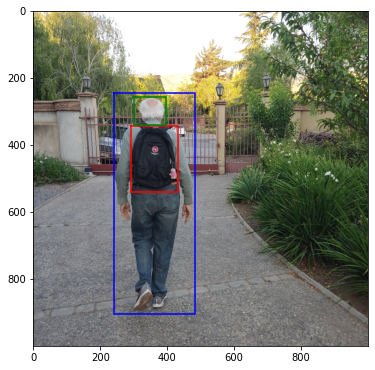

In [4]:
d = dirfiles('mochis/','*.png')
i = 100
fname = d[i] # nombre de imagen i

X = cv2.imread('mochis/'+fname)
plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(X, cv2.COLOR_BGR2RGB))

n = len(df)
# filas que contienen la imagen con nombre fname 
for k in range(n):
  if df.File[k] == fname:
    x1 = df.x1[k]
    x2 = df.x2[k]
    y1 = df.y1[k]
    y2 = df.y2[k]

    if df.obj[k] == 0:
      plt.plot([x1,x1,x2,x2,x1],[y1,y2,y2,y1,y1],c='r')
    elif df.obj[k] == 1:
      plt.plot([x1,x1,x2,x2,x1],[y1,y2,y2,y1,y1],c='g')
    else:
      plt.plot([x1,x1,x2,x2,x1],[y1,y2,y2,y1,y1],c='b')

plt.show()

# 3) Generación de base de datos

Genere la Base de Datos para clasificación entre objetos masculinos/femeninos

> Escoja 500 imágenes de la base de datos 'mochis'

> De estas 500 imágenes, 70% serán destinadas a training, 10% a validation y 20% a testing.

> Escoja un objeto a clasificar (mochila, cabeza, o persona)

> Construya la base de datos con imágenes de 64x64 pixeles del objeto seleccionado (o más, puede ser por ejemplo 128x128)

In [5]:
!mkdir mochilas

!mkdir mochilas/train
!mkdir mochilas/train/femenino
!mkdir mochilas/train/masculino

!mkdir mochilas/val
!mkdir mochilas/val/femenino
!mkdir mochilas/val/masculino

!mkdir mochilas/test
!mkdir mochilas/test/femenino
!mkdir mochilas/test/masculino

In [6]:
import numpy as np
from tqdm.auto import tqdm

mochilas = df[df['obj'] == 0] #Escogimos el objeto mochilas

p_train = 0.70  # 70% de los datos son training
p_val   = 0.10  # 10% de los datos de training son de validación

d = dirfiles('mochis/','*.png')
m = 500 # numero de imagenes

nt = round(p_train*m)
nv = round(p_val*nt)

ii = np.vstack([np.zeros((nt-nv,1)),np.ones((nv,1)),2*np.ones((m-nt,1))])

target = ['train','val','test']

for i in tqdm(range(m)):
  fname            = d[i]
  ti               = target[int(ii[i])]
  source_file      = 'mochis/'+fname
  destination_file = 'mochilas/'+ti

  
  aux = mochilas[mochilas['File'] == fname]

  for i in aux.index:
    x1 = aux.x1[i]
    x2 = aux.x2[i]
    y1 = aux.y1[i]
    y2 = aux.y2[i]

    img = cv2.imread(source_file)
    
    img = img[y1:y2, x1:x2, :]

    img = cv2.resize(img, (128,128))
    
    if aux.gen[i] == 'F':
      cv2.imwrite(destination_file +'/femenino/' + fname, cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
      cv2.imwrite(destination_file +'/masculino/' + fname, cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  
  #os.system('cp ' + source_file + ' ' + destination_file)

print('Training: ', nt-nv)
print('     Val: ', nv)
print(' Testing: ',m-nt)

  0%|          | 0/500 [00:00<?, ?it/s]

Training:  315
     Val:  35
 Testing:  150


# 4) Base de datos balanceada

Genere una nueva base de datos balanceada en el training y en validation usando la librería "Augmentor" (el conjunto de testing no se cambia, debe contener sólo imágenes reales, no aumentadas)

In [7]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import Augmentor

In [9]:
def dirfiles(fpath,fext):
    fnames = fnmatch.filter(sorted(os.listdir(fpath)),fext)
    if '.DS_Store' in fnames:
        fnames.remove('.DS_Store')
    return fnames
def dirdir(fpath):
    fnames = sorted(os.listdir(fpath))
    if '.DS_Store' in fnames:
        fnames.remove('.DS_Store')
    return fnames

def imagesxclass(fpath,fext='*.png'):
  fdir = dirdir(fpath)
  for i in range(len(fdir)):
    x = dirfiles(fpath+'/'+fdir[i]+'/',fext)
    print(i,fdir[i],len(x))


# INCLUDE HERE THE AUGMENTATION FUNCTIONS
def augment(set_name,N):
  ldir = dirdir(PATH_ORIGINAL+set_name)
  for i in range(len(ldir)):
    print('processing '+ldir[i])
    p0 = Augmentor.Pipeline(PATH_ORIGINAL+set_name+'/'+ldir[i],output_directory='../../../'+PATH_AUGMENTED+set_name+'/'+ldir[i])
    p0.set_seed(0)
    #p0.rotate90(probability=0.25)
    #p0.rotate180(probability=0.25)
    #p0.rotate270(probability=0.25)
    p0.flip_left_right(probability=0.5)
    #p0.skew(probability=0.5)
    #p0.flip_random(probability=0.25)
    p0.sample(N)

In [10]:
fpath = 'mochilas/'

PATH_ORIGINAL  = fpath
PATH_AUGMENTED = 'x' + fpath

!mkdir {PATH_AUGMENTED}
!mkdir {PATH_AUGMENTED}train
!mkdir {PATH_AUGMENTED}val

In [11]:
print('Original-Train:')
imagesxclass(PATH_ORIGINAL+'train')
print('Original-Val:')
imagesxclass(PATH_ORIGINAL+'val')
print('Original-Test:')
imagesxclass(PATH_ORIGINAL+'test')

Original-Train:
0 femenino 175
1 masculino 225
Original-Val:
0 femenino 23
1 masculino 26
Original-Test:
0 femenino 82
1 masculino 118


In [12]:
augment('train',300) # each class will be have 300 samples
augment('val',45)   # each class will be have 45 samples

processing femenino
Initialised with 175 image(s) found.
Output directory set to mochilas/train/femenino/../../../xmochilas/train/femenino.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=128x128 at 0x7FD60EAD90D0>: 100%|██████████| 300/300 [00:02<00:00, 142.16 Samples/s]


processing masculino
Initialised with 225 image(s) found.
Output directory set to mochilas/train/masculino/../../../xmochilas/train/masculino.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=128x128 at 0x7FD60AA7A910>: 100%|██████████| 300/300 [00:02<00:00, 121.95 Samples/s]


processing femenino
Initialised with 23 image(s) found.
Output directory set to mochilas/val/femenino/../../../xmochilas/val/femenino.

Processing <PIL.Image.Image image mode=RGB size=128x128 at 0x7FD60AA588D0>: 100%|██████████| 45/45 [00:00<00:00, 96.63 Samples/s] 


processing masculino
Initialised with 26 image(s) found.
Output directory set to mochilas/val/masculino/../../../xmochilas/val/masculino.

Processing <PIL.Image.Image image mode=RGB size=128x128 at 0x7FD60EAF9D10>: 100%|██████████| 45/45 [00:00<00:00, 130.35 Samples/s]


In [13]:
print('Original-Train:')
imagesxclass(PATH_ORIGINAL+'train')
print('Augmented-Train:')
imagesxclass(PATH_AUGMENTED+'train')
print('')
print('Original-Val:')
imagesxclass(PATH_ORIGINAL+'val')
print('Augmented-Val:')
imagesxclass(PATH_AUGMENTED+'val')

Original-Train:
0 femenino 175
1 masculino 225
Augmented-Train:
0 femenino 300
1 masculino 300

Original-Val:
0 femenino 23
1 masculino 26
Augmented-Val:
0 femenino 45
1 masculino 45


In [14]:
# Test subset will be not augmented (only copied)
!cp -r {PATH_ORIGINAL}test {PATH_AUGMENTED}test
fpath = PATH_AUGMENTED

# 5) Loaderdef

Usando la función "loaderdef", cargue los datos de training/validation/testing de esta nueva base de datos de tal forma que no se generen imágenes invertidas.

In [15]:
util = 'pretrain_utils'
utilpy = util+'2.py'
if os.path.isfile(utilpy):
  del sys.modules[util]
  os.remove(utilpy)
  print(util+' removed.')
print(util+' ready to load.')

!wget https://www.dropbox.com/s/5nnub5axbj20e2m/pretrain_utils2.py
!cp pretrain_utils2.py pretrain_utils.py
from pretrain_utils import loaderdef,modeldef,showimages,evaluate,megatrain,printaccm,get_predictions,plot_confusion_matrix
print('pretrain_utils module has been loaded')

pretrain_utils ready to load.
--2022-11-03 03:13:08--  https://www.dropbox.com/s/5nnub5axbj20e2m/pretrain_utils2.py
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/5nnub5axbj20e2m/pretrain_utils2.py [following]
--2022-11-03 03:13:09--  https://www.dropbox.com/s/raw/5nnub5axbj20e2m/pretrain_utils2.py
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd2eedc133da0a6f479d695f3c7.dl.dropboxusercontent.com/cd/0/inline/BwC-sjFWKPWK3lolPoy1sACRxzCl0LxuQu9hf0dyPRhavDQ5fSNI3GGa4QBhHkAwnPrszxY4gcrl9oNrKAURre3VGRJRP5MUAFIqRBViPk_BamymHfo6Lw2pzVP5S6gtyREtIzVn5x-7n0qmD1nwHzbyIiBmnHbPhfll5ryukShsmg/file# [following]
--2022-11-03 03:13:09--  https://ucd2eedc133da0a6f479d695f3c7.dl.dropboxusercontent.com/cd/0/inline/BwC-sjFWKPWK3lolPoy1sACRxzCl0

Number of Samples:
   Train: 600
     Val: 90
    Test: 200


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([3, 224, 224])


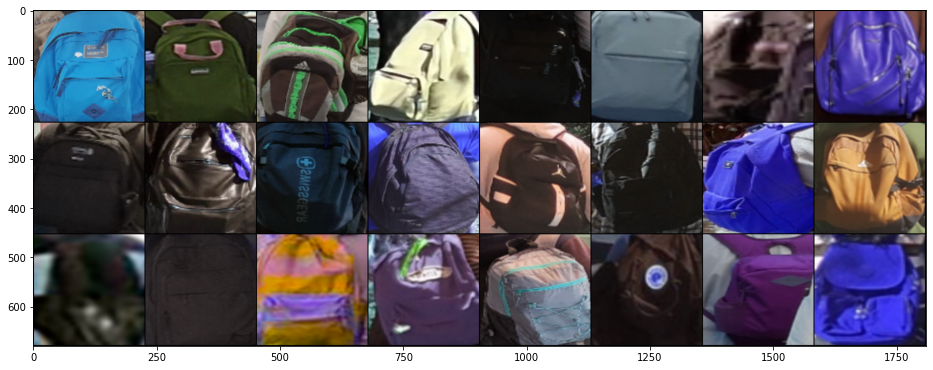

In [26]:
# hyper parameters
BATCH_SIZE    = 32
num_epochs    = 100

# Data Loader and definition of augmentation in training
vflip = 0.0 # it generates vertical   flipped (example: b to p) images with a probability of vflip
hflip = 0.0 # it generates horizontal flipped (example: b to d) images with a probability of hflip 
rot   = 0   # it generate images that have been rotated from -rot to +rot randomly
train_loader,val_loader,test_loader = loaderdef(fpath,False,BATCH_SIZE,show=True,vflip=vflip,hflip=hflip,rot=rot)

# 6) Entrenamiento

Entrene al menos los siguientes tres modelos:

> CNN small (cnn-s)

> VGG-19

> ResNet-34

In [17]:
!mkdir models # in this folder, the trained models will be stored

In [28]:
EARLY_STOP = 10
num_classes = 2

# AVAILABLE MODELS
#model_list = ['cnn','cnn-s','cnn-m','cnn-l',
#              'shufflenet_v2_x1_0','shufflenet_v2_x0_5',
#              'efficientnet_b0','efficientnet_b1','efficientnet_b2','efficientnet_b3',
#              'squeezenet1_0',
#              'mobilenet_v2','mobilenet_v3_small','mobilenet_v3_large',
#              'googlenet','alexnet',
#              'resnet18','resnet34','resnet50','resnet101','resnet152','resnext50_32x4d','wide_resnet50_2',
#              'vgg11','vgg13','vgg16','vgg19',
#              'vgg11_bn','vgg13_bn','vgg16_bn','vgg19_bn',
#              'densenet161','densenet201',
#              'vit_b_16','vit_b_32',
#              ]

model_list = ['cnn-s', 'vgg19', 'resnet18', 'resnet34','squeezenet1_0', 'efficientnet_b3', 'densenet201']
n          = len(model_list)
acc        = np.zeros((n,4))
sta        = np.zeros((n,5))
for i in range(n):
  modelname = model_list[i]
  print(f'{i+1:03}/{n:03} | processing model {modelname}')
  model,modelfamily,trans_norm = modeldef(modelname,num_classes)
  train_loader,val_loader,test_loader = loaderdef(fpath,trans_norm,BATCH_SIZE)
  acc[i,:],sta[i,:] = megatrain(model,modelname,modelfamily,train_loader,val_loader,test_loader,num_epochs,early_stop=EARLY_STOP)
  printaccm(acc,sta,i,model_list)

001/007 | processing model cnn-s
name:  cnn-s  family:  cnn
Number of cnn features =  1024
Trainable parameters: 966,160 
random initial weights...


Searching best LR:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 000 | Epoch Time: 0m 4s |  Train Acc: 0.4929 |  Val Acc: 0.6378 * |  Test Acc: 0.5759


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 001 | Epoch Time: 0m 4s |  Train Acc: 0.5663 |  Val Acc: 0.6402 * |  Test Acc: 0.6161


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 002 | Epoch Time: 0m 4s |  Train Acc: 0.5433 |  Val Acc: 0.5417   |  Test Acc: 0.5759


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 003 | Epoch Time: 0m 4s |  Train Acc: 0.5740 |  Val Acc: 0.6370   |  Test Acc: 0.5893


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 004 | Epoch Time: 0m 4s |  Train Acc: 0.5910 |  Val Acc: 0.5753   |  Test Acc: 0.6071


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 005 | Epoch Time: 0m 4s |  Train Acc: 0.6080 |  Val Acc: 0.6402   |  Test Acc: 0.6518


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 006 | Epoch Time: 0m 4s |  Train Acc: 0.5872 |  Val Acc: 0.6418 * |  Test Acc: 0.6339


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 007 | Epoch Time: 0m 4s |  Train Acc: 0.5789 |  Val Acc: 0.5545   |  Test Acc: 0.6250


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 008 | Epoch Time: 0m 4s |  Train Acc: 0.6069 |  Val Acc: 0.6426 * |  Test Acc: 0.6205


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 009 | Epoch Time: 0m 4s |  Train Acc: 0.5943 |  Val Acc: 0.6138   |  Test Acc: 0.6205


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 010 | Epoch Time: 0m 4s |  Train Acc: 0.5981 |  Val Acc: 0.6114   |  Test Acc: 0.6116


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 011 | Epoch Time: 0m 4s |  Train Acc: 0.6458 |  Val Acc: 0.6787 * |  Test Acc: 0.6161


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 012 | Epoch Time: 0m 4s |  Train Acc: 0.6552 |  Val Acc: 0.6546   |  Test Acc: 0.6071


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 013 | Epoch Time: 0m 5s |  Train Acc: 0.6584 |  Val Acc: 0.6298   |  Test Acc: 0.6562


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 014 | Epoch Time: 0m 4s |  Train Acc: 0.6771 |  Val Acc: 0.6659   |  Test Acc: 0.6205


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 015 | Epoch Time: 0m 4s |  Train Acc: 0.6859 |  Val Acc: 0.6482   |  Test Acc: 0.6071


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 016 | Epoch Time: 0m 4s |  Train Acc: 0.7056 |  Val Acc: 0.7228 * |  Test Acc: 0.6652


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 017 | Epoch Time: 0m 4s |  Train Acc: 0.6875 |  Val Acc: 0.6763   |  Test Acc: 0.6205


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 018 | Epoch Time: 0m 5s |  Train Acc: 0.6941 |  Val Acc: 0.6090   |  Test Acc: 0.6339


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 019 | Epoch Time: 0m 4s |  Train Acc: 0.6749 |  Val Acc: 0.5962   |  Test Acc: 0.6384


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 020 | Epoch Time: 0m 4s |  Train Acc: 0.7133 |  Val Acc: 0.5288   |  Test Acc: 0.6205


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 021 | Epoch Time: 0m 4s |  Train Acc: 0.7363 |  Val Acc: 0.5665   |  Test Acc: 0.6786


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 022 | Epoch Time: 0m 4s |  Train Acc: 0.7582 |  Val Acc: 0.5080   |  Test Acc: 0.6652


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 023 | Epoch Time: 0m 4s |  Train Acc: 0.7467 |  Val Acc: 0.4976   |  Test Acc: 0.6205


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 024 | Epoch Time: 0m 4s |  Train Acc: 0.7363 |  Val Acc: 0.5785   |  Test Acc: 0.6116


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 025 | Epoch Time: 0m 4s |  Train Acc: 0.7473 |  Val Acc: 0.6242   |  Test Acc: 0.6250


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 026 | Epoch Time: 0m 4s |  Train Acc: 0.7346 |  Val Acc: 0.5256   |  Test Acc: 0.5759
Early stop after  10  epochs...
Best model saved in models/best_model_cnn-s.pt.
Best results (accuracy):
-------------------------------------------------------------------------------------------------------------
 i  | Model                 |  Delta  |    Time  |   Params  |  Feats   | Epochs | Train  |  Val   |   Test
-------------------------------------------------------------------------------------------------------------
001 | cnn-s                 |  4.4266 |   1.9182 |    0.4434 |  1.0240  |    27  | 0.7056 | 0.7228 |  0.6652 
-------------------------------------------------------------------------------------------------------------
002/007 | processing model vgg19
name:  vgg19  family:  vgg
Number of vgg features =  4096
Trainable parameters: 139,578,434 


Searching best LR:   0%|          | 0/100 [00:00<?, ?it/s]

Early stop in LR searching.


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 000 | Epoch Time: 0m 17s |  Train Acc: 0.5828 |  Val Acc: 0.4143 * |  Test Acc: 0.6652


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 001 | Epoch Time: 0m 18s |  Train Acc: 0.7577 |  Val Acc: 0.4455 * |  Test Acc: 0.6295


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 002 | Epoch Time: 0m 17s |  Train Acc: 0.8098 |  Val Acc: 0.4535 * |  Test Acc: 0.6429


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 003 | Epoch Time: 0m 17s |  Train Acc: 0.8947 |  Val Acc: 0.4712 * |  Test Acc: 0.6071


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 004 | Epoch Time: 0m 17s |  Train Acc: 0.8936 |  Val Acc: 0.5497 * |  Test Acc: 0.6250


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 005 | Epoch Time: 0m 17s |  Train Acc: 0.9397 |  Val Acc: 0.5777 * |  Test Acc: 0.6295


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 006 | Epoch Time: 0m 17s |  Train Acc: 0.9145 |  Val Acc: 0.5809 * |  Test Acc: 0.5759


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 007 | Epoch Time: 0m 14s |  Train Acc: 0.9041 |  Val Acc: 0.4631   |  Test Acc: 0.6116


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 008 | Epoch Time: 0m 17s |  Train Acc: 0.9205 |  Val Acc: 0.6010 * |  Test Acc: 0.6161


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 009 | Epoch Time: 0m 14s |  Train Acc: 0.9644 |  Val Acc: 0.5962   |  Test Acc: 0.6384


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 010 | Epoch Time: 0m 14s |  Train Acc: 0.9561 |  Val Acc: 0.4768   |  Test Acc: 0.6875


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 011 | Epoch Time: 0m 17s |  Train Acc: 0.9474 |  Val Acc: 0.6242 * |  Test Acc: 0.6652


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 012 | Epoch Time: 0m 14s |  Train Acc: 0.9611 |  Val Acc: 0.5128   |  Test Acc: 0.6339


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 013 | Epoch Time: 0m 14s |  Train Acc: 0.9814 |  Val Acc: 0.4559   |  Test Acc: 0.6295


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 014 | Epoch Time: 0m 15s |  Train Acc: 0.9737 |  Val Acc: 0.5417   |  Test Acc: 0.6473


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 015 | Epoch Time: 0m 14s |  Train Acc: 0.9885 |  Val Acc: 0.4880   |  Test Acc: 0.6652


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 016 | Epoch Time: 0m 14s |  Train Acc: 0.9803 |  Val Acc: 0.5024   |  Test Acc: 0.6652


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 017 | Epoch Time: 0m 15s |  Train Acc: 0.9485 |  Val Acc: 0.4511   |  Test Acc: 0.5982


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 018 | Epoch Time: 0m 15s |  Train Acc: 0.9814 |  Val Acc: 0.4864   |  Test Acc: 0.6339


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 019 | Epoch Time: 0m 15s |  Train Acc: 0.9857 |  Val Acc: 0.5849   |  Test Acc: 0.6295


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 020 | Epoch Time: 0m 14s |  Train Acc: 0.9704 |  Val Acc: 0.4712   |  Test Acc: 0.6116


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 021 | Epoch Time: 0m 15s |  Train Acc: 0.9704 |  Val Acc: 0.5465   |  Test Acc: 0.6071
Early stop after  10  epochs...
Best model saved in models/best_model_vgg19.pt.
Best results (accuracy):
-------------------------------------------------------------------------------------------------------------
 i  | Model                 |  Delta  |    Time  |   Params  |  Feats   | Epochs | Train  |  Val   |   Test
-------------------------------------------------------------------------------------------------------------
001 | cnn-s                 |  4.4266 |   1.9182 |    0.4434 |  1.0240  |    27  | 0.7056 | 0.7228 |  0.6652 
002 | vgg19                 | 15.0908 |   5.2818 |  139.5784 |  4.0960  |    22  | 0.9474 | 0.6242 |  0.6652 
-------------------------------------------------------------------------------------------------------------
003/007 | processing model resnet18


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

name:  resnet18  family:  resnet
Number of resnet features =  512
Trainable parameters: 11,177,538 


Searching best LR:   0%|          | 0/100 [00:00<?, ?it/s]

Early stop in LR searching.


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 000 | Epoch Time: 0m 5s |  Train Acc: 0.6338 |  Val Acc: 0.4431 * |  Test Acc: 0.5536


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 001 | Epoch Time: 0m 5s |  Train Acc: 0.7659 |  Val Acc: 0.5497 * |  Test Acc: 0.6295


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 002 | Epoch Time: 0m 6s |  Train Acc: 0.8026 |  Val Acc: 0.6010 * |  Test Acc: 0.6161


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 003 | Epoch Time: 0m 5s |  Train Acc: 0.8569 |  Val Acc: 0.5393   |  Test Acc: 0.5491


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 004 | Epoch Time: 0m 5s |  Train Acc: 0.9232 |  Val Acc: 0.4928   |  Test Acc: 0.6250


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 005 | Epoch Time: 0m 5s |  Train Acc: 0.9353 |  Val Acc: 0.5521   |  Test Acc: 0.6161


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 006 | Epoch Time: 0m 5s |  Train Acc: 0.9293 |  Val Acc: 0.5361   |  Test Acc: 0.6161


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 007 | Epoch Time: 0m 5s |  Train Acc: 0.9249 |  Val Acc: 0.5489   |  Test Acc: 0.6295


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 008 | Epoch Time: 0m 5s |  Train Acc: 0.9183 |  Val Acc: 0.5545   |  Test Acc: 0.6429


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 009 | Epoch Time: 0m 5s |  Train Acc: 0.9370 |  Val Acc: 0.5441   |  Test Acc: 0.6295


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 010 | Epoch Time: 0m 6s |  Train Acc: 0.9337 |  Val Acc: 0.6170 * |  Test Acc: 0.6116


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 011 | Epoch Time: 0m 5s |  Train Acc: 0.9161 |  Val Acc: 0.5753   |  Test Acc: 0.6339


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 012 | Epoch Time: 0m 5s |  Train Acc: 0.9633 |  Val Acc: 0.5729   |  Test Acc: 0.6473


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 013 | Epoch Time: 0m 5s |  Train Acc: 0.9715 |  Val Acc: 0.4327   |  Test Acc: 0.6875


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 014 | Epoch Time: 0m 5s |  Train Acc: 0.9567 |  Val Acc: 0.4952   |  Test Acc: 0.6250


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 015 | Epoch Time: 0m 5s |  Train Acc: 0.9731 |  Val Acc: 0.6402 * |  Test Acc: 0.6429


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 016 | Epoch Time: 0m 5s |  Train Acc: 0.9879 |  Val Acc: 0.6082   |  Test Acc: 0.6830


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 017 | Epoch Time: 0m 5s |  Train Acc: 0.9786 |  Val Acc: 0.4928   |  Test Acc: 0.6161


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 018 | Epoch Time: 0m 5s |  Train Acc: 0.9698 |  Val Acc: 0.5417   |  Test Acc: 0.6250


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 019 | Epoch Time: 0m 6s |  Train Acc: 0.9633 |  Val Acc: 0.3990   |  Test Acc: 0.6205


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 020 | Epoch Time: 0m 5s |  Train Acc: 0.9589 |  Val Acc: 0.4976   |  Test Acc: 0.6116


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 021 | Epoch Time: 0m 5s |  Train Acc: 0.9671 |  Val Acc: 0.5673   |  Test Acc: 0.6384


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 022 | Epoch Time: 0m 5s |  Train Acc: 0.9770 |  Val Acc: 0.6298   |  Test Acc: 0.6607


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 023 | Epoch Time: 0m 5s |  Train Acc: 0.9786 |  Val Acc: 0.6426 * |  Test Acc: 0.6116


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 024 | Epoch Time: 0m 6s |  Train Acc: 0.9846 |  Val Acc: 0.6522 * |  Test Acc: 0.6607


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 025 | Epoch Time: 0m 5s |  Train Acc: 0.9715 |  Val Acc: 0.5729   |  Test Acc: 0.6116


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 026 | Epoch Time: 0m 5s |  Train Acc: 0.9786 |  Val Acc: 0.6186   |  Test Acc: 0.6250


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 027 | Epoch Time: 0m 6s |  Train Acc: 0.9720 |  Val Acc: 0.4864   |  Test Acc: 0.6116


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 028 | Epoch Time: 0m 5s |  Train Acc: 0.9792 |  Val Acc: 0.5649   |  Test Acc: 0.6607


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 029 | Epoch Time: 0m 5s |  Train Acc: 0.9682 |  Val Acc: 0.5641   |  Test Acc: 0.6205


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 030 | Epoch Time: 0m 5s |  Train Acc: 0.9507 |  Val Acc: 0.6322   |  Test Acc: 0.6786


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 031 | Epoch Time: 0m 5s |  Train Acc: 0.9507 |  Val Acc: 0.5905   |  Test Acc: 0.5982


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 032 | Epoch Time: 0m 5s |  Train Acc: 0.9786 |  Val Acc: 0.6370   |  Test Acc: 0.6250


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 033 | Epoch Time: 0m 5s |  Train Acc: 0.9901 |  Val Acc: 0.5954   |  Test Acc: 0.6295


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 034 | Epoch Time: 0m 5s |  Train Acc: 0.9753 |  Val Acc: 0.6114   |  Test Acc: 0.6339
Early stop after  10  epochs...
Best model saved in models/best_model_resnet18.pt.
Best results (accuracy):
-------------------------------------------------------------------------------------------------------------
 i  | Model                 |  Delta  |    Time  |   Params  |  Feats   | Epochs | Train  |  Val   |   Test
-------------------------------------------------------------------------------------------------------------
001 | cnn-s                 |  4.4266 |   1.9182 |    0.4434 |  1.0240  |    27  | 0.7056 | 0.7228 |  0.6652 
002 | vgg19                 | 15.0908 |   5.2818 |  139.5784 |  4.0960  |    22  | 0.9474 | 0.6242 |  0.6652 
003 | resnet18              |  5.4846 |   3.1079 |   11.1775 |  0.5120  |    35  | 0.9846 | 0.6522 |  0.6607 
-------------------------------------------------------------------------------------------------------------
004/007 | processing model resn

Searching best LR:   0%|          | 0/100 [00:00<?, ?it/s]

Early stop in LR searching.


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 000 | Epoch Time: 0m 6s |  Train Acc: 0.5713 |  Val Acc: 0.5000 * |  Test Acc: 0.4152


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 001 | Epoch Time: 0m 6s |  Train Acc: 0.6316 |  Val Acc: 0.6162 * |  Test Acc: 0.5714


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 002 | Epoch Time: 0m 6s |  Train Acc: 0.6689 |  Val Acc: 0.4848   |  Test Acc: 0.5536


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 003 | Epoch Time: 0m 6s |  Train Acc: 0.7747 |  Val Acc: 0.5000   |  Test Acc: 0.5491


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 004 | Epoch Time: 0m 6s |  Train Acc: 0.8092 |  Val Acc: 0.3630   |  Test Acc: 0.5402


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 005 | Epoch Time: 0m 6s |  Train Acc: 0.8410 |  Val Acc: 0.6138   |  Test Acc: 0.5938


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 006 | Epoch Time: 0m 6s |  Train Acc: 0.8602 |  Val Acc: 0.5000   |  Test Acc: 0.5804


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 007 | Epoch Time: 0m 6s |  Train Acc: 0.8629 |  Val Acc: 0.5369   |  Test Acc: 0.5580


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 008 | Epoch Time: 0m 7s |  Train Acc: 0.8750 |  Val Acc: 0.4247   |  Test Acc: 0.5804


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 009 | Epoch Time: 0m 6s |  Train Acc: 0.8986 |  Val Acc: 0.5048   |  Test Acc: 0.5714


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 010 | Epoch Time: 0m 7s |  Train Acc: 0.9046 |  Val Acc: 0.6498 * |  Test Acc: 0.5759


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 011 | Epoch Time: 0m 7s |  Train Acc: 0.9008 |  Val Acc: 0.4896   |  Test Acc: 0.5268


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 012 | Epoch Time: 0m 6s |  Train Acc: 0.8947 |  Val Acc: 0.5825   |  Test Acc: 0.6161


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 013 | Epoch Time: 0m 6s |  Train Acc: 0.9013 |  Val Acc: 0.5369   |  Test Acc: 0.5982


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 014 | Epoch Time: 0m 6s |  Train Acc: 0.9265 |  Val Acc: 0.6090   |  Test Acc: 0.5938


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 015 | Epoch Time: 0m 6s |  Train Acc: 0.9359 |  Val Acc: 0.5417   |  Test Acc: 0.4464


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 016 | Epoch Time: 0m 6s |  Train Acc: 0.9435 |  Val Acc: 0.6218   |  Test Acc: 0.5357


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 017 | Epoch Time: 0m 7s |  Train Acc: 0.9424 |  Val Acc: 0.4816   |  Test Acc: 0.5938


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 018 | Epoch Time: 0m 7s |  Train Acc: 0.9271 |  Val Acc: 0.4912   |  Test Acc: 0.5536


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 019 | Epoch Time: 0m 7s |  Train Acc: 0.9419 |  Val Acc: 0.5184   |  Test Acc: 0.6161


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 020 | Epoch Time: 0m 6s |  Train Acc: 0.9402 |  Val Acc: 0.5513   |  Test Acc: 0.7277
Early stop after  10  epochs...
Best model saved in models/best_model_resnet34.pt.
Best results (accuracy):
-------------------------------------------------------------------------------------------------------------
 i  | Model                 |  Delta  |    Time  |   Params  |  Feats   | Epochs | Train  |  Val   |   Test
-------------------------------------------------------------------------------------------------------------
001 | cnn-s                 |  4.4266 |   1.9182 |    0.4434 |  1.0240  |    27  | 0.7056 | 0.7228 |  0.6652 
002 | vgg19                 | 15.0908 |   5.2818 |  139.5784 |  4.0960  |    22  | 0.9474 | 0.6242 |  0.6652 
003 | resnet18              |  5.4846 |   3.1079 |   11.1775 |  0.5120  |    35  | 0.9846 | 0.6522 |  0.6607 
004 | resnet34              |  6.6568 |   2.2189 |   21.2857 |  0.5120  |    21  | 0.9046 | 0.6498 |  0.5759 
-------------------------------

Searching best LR:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 000 | Epoch Time: 0m 5s |  Train Acc: 0.4605 |  Val Acc: 0.4976 * |  Test Acc: 0.4598


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 001 | Epoch Time: 0m 6s |  Train Acc: 0.5033 |  Val Acc: 0.5072 * |  Test Acc: 0.4196


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 002 | Epoch Time: 0m 5s |  Train Acc: 0.5367 |  Val Acc: 0.5000   |  Test Acc: 0.4196


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 003 | Epoch Time: 0m 5s |  Train Acc: 0.4715 |  Val Acc: 0.4880   |  Test Acc: 0.4196


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 004 | Epoch Time: 0m 5s |  Train Acc: 0.5143 |  Val Acc: 0.4928   |  Test Acc: 0.4196


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 005 | Epoch Time: 0m 5s |  Train Acc: 0.4989 |  Val Acc: 0.4928   |  Test Acc: 0.4196


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 006 | Epoch Time: 0m 5s |  Train Acc: 0.4901 |  Val Acc: 0.5024   |  Test Acc: 0.4062


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 007 | Epoch Time: 0m 5s |  Train Acc: 0.5027 |  Val Acc: 0.5048   |  Test Acc: 0.4330


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 008 | Epoch Time: 0m 5s |  Train Acc: 0.4846 |  Val Acc: 0.5024   |  Test Acc: 0.4330


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 009 | Epoch Time: 0m 6s |  Train Acc: 0.5033 |  Val Acc: 0.5024   |  Test Acc: 0.4196


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 010 | Epoch Time: 0m 5s |  Train Acc: 0.5170 |  Val Acc: 0.5000   |  Test Acc: 0.3795


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 011 | Epoch Time: 0m 5s |  Train Acc: 0.4951 |  Val Acc: 0.4976   |  Test Acc: 0.4062
Early stop after  10  epochs...
Best model saved in models/best_model_squeezenet1_0.pt.
Best results (accuracy):
-------------------------------------------------------------------------------------------------------------
 i  | Model                 |  Delta  |    Time  |   Params  |  Feats   | Epochs | Train  |  Val   |   Test
-------------------------------------------------------------------------------------------------------------
001 | cnn-s                 |  4.4266 |   1.9182 |    0.4434 |  1.0240  |    27  | 0.7056 | 0.7228 |  0.6652 
002 | vgg19                 | 15.0908 |   5.2818 |  139.5784 |  4.0960  |    22  | 0.9474 | 0.6242 |  0.6652 
003 | resnet18              |  5.4846 |   3.1079 |   11.1775 |  0.5120  |    35  | 0.9846 | 0.6522 |  0.6607 
004 | resnet34              |  6.6568 |   2.2189 |   21.2857 |  0.5120  |    21  | 0.9046 | 0.6498 |  0.5759 
005 | squeezenet1_0       

Searching best LR:   0%|          | 0/100 [00:00<?, ?it/s]

Early stop in LR searching.


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 000 | Epoch Time: 0m 10s |  Train Acc: 0.5510 |  Val Acc: 0.5128 * |  Test Acc: 0.5491


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 001 | Epoch Time: 0m 10s |  Train Acc: 0.6732 |  Val Acc: 0.5849 * |  Test Acc: 0.5357


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 002 | Epoch Time: 0m 10s |  Train Acc: 0.7440 |  Val Acc: 0.5929 * |  Test Acc: 0.5759


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 003 | Epoch Time: 0m 10s |  Train Acc: 0.7966 |  Val Acc: 0.5857   |  Test Acc: 0.5357


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 004 | Epoch Time: 0m 10s |  Train Acc: 0.8262 |  Val Acc: 0.5929   |  Test Acc: 0.5625


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 005 | Epoch Time: 0m 10s |  Train Acc: 0.8509 |  Val Acc: 0.5337   |  Test Acc: 0.5759


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 006 | Epoch Time: 0m 10s |  Train Acc: 0.8936 |  Val Acc: 0.5521   |  Test Acc: 0.5670


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 007 | Epoch Time: 0m 10s |  Train Acc: 0.9073 |  Val Acc: 0.5361   |  Test Acc: 0.5223


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 008 | Epoch Time: 0m 10s |  Train Acc: 0.9227 |  Val Acc: 0.5681   |  Test Acc: 0.5670


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 009 | Epoch Time: 0m 10s |  Train Acc: 0.9556 |  Val Acc: 0.5649   |  Test Acc: 0.5670


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 010 | Epoch Time: 0m 10s |  Train Acc: 0.9468 |  Val Acc: 0.6090 * |  Test Acc: 0.5759


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 011 | Epoch Time: 0m 10s |  Train Acc: 0.9693 |  Val Acc: 0.5264   |  Test Acc: 0.6116


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 012 | Epoch Time: 0m 10s |  Train Acc: 0.9786 |  Val Acc: 0.5417   |  Test Acc: 0.6116


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 013 | Epoch Time: 0m 10s |  Train Acc: 0.9868 |  Val Acc: 0.5545   |  Test Acc: 0.6161


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 014 | Epoch Time: 0m 10s |  Train Acc: 0.9836 |  Val Acc: 0.5625   |  Test Acc: 0.5804


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 015 | Epoch Time: 0m 10s |  Train Acc: 0.9775 |  Val Acc: 0.5361   |  Test Acc: 0.5804


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 016 | Epoch Time: 0m 10s |  Train Acc: 0.9885 |  Val Acc: 0.4904   |  Test Acc: 0.6250


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 017 | Epoch Time: 0m 10s |  Train Acc: 0.9803 |  Val Acc: 0.5545   |  Test Acc: 0.6339


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 018 | Epoch Time: 0m 10s |  Train Acc: 1.0000 |  Val Acc: 0.5881   |  Test Acc: 0.6071


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 019 | Epoch Time: 0m 10s |  Train Acc: 0.9808 |  Val Acc: 0.5753   |  Test Acc: 0.6205


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 020 | Epoch Time: 0m 10s |  Train Acc: 0.9967 |  Val Acc: 0.5673   |  Test Acc: 0.6562
Early stop after  10  epochs...
Best model saved in models/best_model_efficientnet_b3.pt.
Best results (accuracy):
-------------------------------------------------------------------------------------------------------------
 i  | Model                 |  Delta  |    Time  |   Params  |  Feats   | Epochs | Train  |  Val   |   Test
-------------------------------------------------------------------------------------------------------------
001 | cnn-s                 |  4.4266 |   1.9182 |    0.4434 |  1.0240  |    27  | 0.7056 | 0.7228 |  0.6652 
002 | vgg19                 | 15.0908 |   5.2818 |  139.5784 |  4.0960  |    22  | 0.9474 | 0.6242 |  0.6652 
003 | resnet18              |  5.4846 |   3.1079 |   11.1775 |  0.5120  |    35  | 0.9846 | 0.6522 |  0.6607 
004 | resnet34              |  6.6568 |   2.2189 |   21.2857 |  0.5120  |    21  | 0.9046 | 0.6498 |  0.5759 
005 | squeezenet1_0    

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

name:  densenet201  family:  densenet
Number of densenet features =  1920
Trainable parameters: 20,017,770 


Searching best LR:   0%|          | 0/100 [00:00<?, ?it/s]

Early stop in LR searching.


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 000 | Epoch Time: 0m 15s |  Train Acc: 0.3257 |  Val Acc: 0.5256 * |  Test Acc: 0.4777


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 001 | Epoch Time: 0m 15s |  Train Acc: 0.8306 |  Val Acc: 0.5136   |  Test Acc: 0.5312


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 002 | Epoch Time: 0m 14s |  Train Acc: 0.9134 |  Val Acc: 0.4663   |  Test Acc: 0.5357


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 003 | Epoch Time: 0m 15s |  Train Acc: 0.9446 |  Val Acc: 0.4527   |  Test Acc: 0.5491


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 004 | Epoch Time: 0m 15s |  Train Acc: 0.9600 |  Val Acc: 0.4383   |  Test Acc: 0.5491


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 005 | Epoch Time: 0m 15s |  Train Acc: 0.9748 |  Val Acc: 0.5208   |  Test Acc: 0.5848


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 006 | Epoch Time: 0m 15s |  Train Acc: 0.9885 |  Val Acc: 0.4399   |  Test Acc: 0.5804


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 007 | Epoch Time: 0m 15s |  Train Acc: 0.9967 |  Val Acc: 0.4527   |  Test Acc: 0.5670


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 008 | Epoch Time: 0m 15s |  Train Acc: 0.9951 |  Val Acc: 0.4199   |  Test Acc: 0.5625


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 009 | Epoch Time: 0m 15s |  Train Acc: 0.9934 |  Val Acc: 0.4151   |  Test Acc: 0.5759


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Testing:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 010 | Epoch Time: 0m 16s |  Train Acc: 0.9967 |  Val Acc: 0.4511   |  Test Acc: 0.6161
Early stop after  10  epochs...
Best model saved in models/best_model_densenet201.pt.
Best results (accuracy):
-------------------------------------------------------------------------------------------------------------
 i  | Model                 |  Delta  |    Time  |   Params  |  Feats   | Epochs | Train  |  Val   |   Test
-------------------------------------------------------------------------------------------------------------
001 | cnn-s                 |  4.4266 |   1.9182 |    0.4434 |  1.0240  |    27  | 0.7056 | 0.7228 |  0.6652 
002 | vgg19                 | 15.0908 |   5.2818 |  139.5784 |  4.0960  |    22  | 0.9474 | 0.6242 |  0.6652 
003 | resnet18              |  5.4846 |   3.1079 |   11.1775 |  0.5120  |    35  | 0.9846 | 0.6522 |  0.6607 
004 | resnet34              |  6.6568 |   2.2189 |   21.2857 |  0.5120  |    21  | 0.9046 | 0.6498 |  0.5759 
005 | squeezenet1_0        

# 7) Matriz de confusión 

Encuentre la Matriz de Confusión en el Testing del mejor modelo

In [21]:
import torch
from torchvision import models

In [29]:
import torch.nn as nn
besti = np.argmax(acc[:,1]) # best model: best accuracy in validation set
modelname   = model_list[besti]
model,modelfamily,trans_norm = modeldef(modelname,num_classes)
train_loader,val_loader,test_loader = loaderdef(fpath,trans_norm,BATCH_SIZE)
device      = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion   = nn.CrossEntropyLoss()
model       = model.to(device)
criterion   = criterion.to(device)

model.load_state_dict(torch.load('models/best_model_'+modelname+'.pt'))
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

name:  cnn-s  family:  cnn
Number of cnn features =  1024
Trainable parameters: 966,160 
random initial weights...


Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Test Loss: 0.669 | Test Acc: 69.20%


  0%|          | 0/7 [00:00<?, ?it/s]

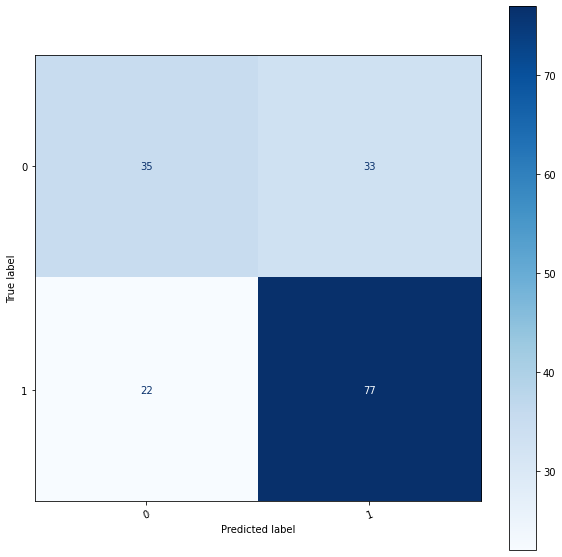

In [30]:
ld = test_loader # val_loader or train_loader

images, labels, probs = get_predictions(model,ld,device)
pred_labels = torch.argmax(probs,1)
plot_confusion_matrix(labels,pred_labels,range(num_classes),norm=True)